In [1]:
#@title Import Modules
import math
import functools
import random

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn.functional as F
import torchvision.models as models

from collections import Counter
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms

In [2]:
#@title Define Hyperparameters
if(torch.backends.mps.is_available()):
    device = 'mps'
elif (torch.cuda.is_available()):
    device = 'cuda'
else:
    device = 'cpu'

# Experiment parameters
tasks           = [(0,2), (5,6), (3,8)]
dataset         = datasets.MNIST
transform       = transforms.ToTensor()
train_batch_size= 512
test_batch_size = 512

# Training Parameters
epochs          = 10
offline_lr      = 7e-2
milestones      = [epochs//2]
gamma           = 0.5
batch_size      = 512
momentum        = 0
weight_decay    = 0

# Mutual Information Parameters
n_bins          = 100

In [3]:
pca_components = 12

#@title Data Retrieval
def process_data(data, task):
    conditions = []
    for c in task:
      conditions.append((data.targets == c))
    indices = functools.reduce(torch.logical_or, conditions)
    data.data, data.targets = data.data[indices], data.targets[indices]
    for i in range(len(task)):
      data.targets[data.targets == task[i]] = i
    data = TensorDataset(data.data.reshape(-1, 28*28), data.targets)
    return data

def get_train_loader(task):
    train_dataset = process_data(dataset('../data', download=True, train=True, transform=transform), task)
    test_dataset  = process_data(dataset('../data', download=True, train=False, transform=transform), task)

    # use PCA to reduce to lower dimensions
    pca = PCA(n_components=pca_components)
    pca.fit(train_dataset.tensors[0])
    train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])
    test_dataset.tensors  = (torch.from_numpy(pca.transform(test_dataset.tensors[0])).float(), test_dataset.tensors[1])

    # Make dataset loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True
    )
    return train_loader

def get_test_loader(task):
    train_dataset = process_data(dataset('../data', download=True, train=True, transform=transform), task)
    test_dataset  = process_data(dataset('../data', download=True, train=False, transform=transform), task)

    # use PCA to reduce to lower dimensions
    pca = PCA(n_components=pca_components)
    pca.fit(train_dataset.tensors[0])
    train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])
    test_dataset.tensors  = (torch.from_numpy(pca.transform(test_dataset.tensors[0])).float(), test_dataset.tensors[1])
    test_loader   = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, shuffle=False, drop_last=False
    )
    return test_loader

def get_MI_loader(task):
    train_dataset = process_data(dataset('../data', download=True, train=True, transform=transform), task)

    # use PCA to reduce to lower dimensions
    pca = PCA(n_components=pca_components)
    pca.fit(train_dataset.tensors[0])
    train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])

    # Make dataset loaders
    MI_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=len(train_dataset), shuffle=False, drop_last=False
    )
    return MI_loader

In [4]:
def make_test_tracker(num_tasks):
    test_tracker = {}
    for task_num in range(num_tasks):
        test_tracker[task_num] = {}
        for test_task_num in range(task_num+1):
            test_tracker[task_num][test_task_num] = []
    return test_tracker

def update_test_tracker(test_tracker, model, class_heads, task_num, test_loaders):
    # test tasks individually
    model.eval()
    for test_task_num in range(task_num + 1):
        test_loader = test_loaders[test_task_num]
        N = 0
        accuracy = 0
        for batch_idx, (images, labels) in enumerate(test_loader, start=1):
            images, labels = images.to(device), labels.to(device)

            # forward pass
            h1, h2, h3, h4, h5 = model(images)
            h6 = F.log_softmax(class_heads[test_task_num](h5), dim = 1)

            # check if predicted labels are equal to true labels
            predicted_labels = torch.argmax(h6,dim=1)
            accuracy += torch.sum((predicted_labels==labels).float()).item()
            N += images.shape[0]
        test_tracker[task_num][test_task_num].append(100. * accuracy/N)

In [5]:
#@title Information Computers
def compute_mutual_information(model, class_heads, taskNum, data_loader):
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

    h_list = model(images)
    h6 = F.log_softmax(class_heads[taskNum](h_list[-1]), dim = 1)
    h_list = h_list + (h6, )

    # calculate mutual information
    layers = len(h_list)
    MI_XH = torch.zeros(layers)
    MI_YH = torch.zeros(layers)
    for layer, h in enumerate(h_list):
        # discretize images and representations
        bins = np.linspace(0, 1, n_bins+1)
        x_ = np.digitize(images.cpu(), bins)
        if layer == layers-1:
            h = torch.exp(h)
            bins = np.linspace(0, 1, n_bins+1)
        else:
            bins = np.linspace(-1, 1, n_bins+1)
        h_ = np.digitize(h.cpu().detach().numpy(), bins)
        y_ = labels.cpu()

        # calculate discrete probabilities
        p_X = Counter()
        p_Y = Counter()
        p_H = Counter()
        p_XH = Counter()
        p_YH = Counter()

        for x_i, h_i, y_i in zip(x_, h_, y_):
            def totuple(a):
                try:
                    return tuple(totuple(i) for i in a)
                except:
                    return a.item()

            unit = 1./len(images)

            p_X[totuple(x_i)]                   += unit
            p_Y[totuple(y_i)]                   += unit
            p_H[totuple(h_i)]                   += unit
            p_XH[(totuple(x_i), totuple(h_i))]  += unit
            p_YH[(totuple(y_i), totuple(h_i))]  += unit

        for xh in p_XH:
            if p_XH[xh] != 0:
                MI_XH[layer] += p_XH[xh] * math.log2(p_XH[xh] / (p_X[xh[0]] * p_H[xh[1]]))

        for yh in p_YH:
            if p_YH[yh] != 0:
                MI_YH[layer] += p_YH[yh] * math.log2(p_YH[yh] / (p_Y[yh[0]] * p_H[yh[1]]))
    return MI_XH, MI_YH

def compute_shannon_entropy(data_loader):
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
    bins = np.linspace(0, 1, n_bins+1)
    x_ = np.digitize(images.cpu(), bins)
    y_ = labels.cpu()
    p_X = Counter()
    p_Y = Counter()
    for x_i, y_i in zip(x_, y_):
        def totuple(a):
            try:
                return tuple(totuple(i) for i in a)
            except:
                return a.item()

        unit = 1./len(images)

        p_X[totuple(x_i)]                   += unit
        p_Y[totuple(y_i)]                   += unit
    X = 0
    for x in p_X:
        X -= p_X[x] * math.log2(p_X[x])
    Y = 0
    for y in p_Y:
        Y -= p_Y[y] * math.log2(p_Y[y])
    return X, Y

In [6]:
#@title Define Model
class Model(nn.Module):
    def __init__(self):
      super(Model, self).__init__()
      self.fc1 = nn.Linear(pca_components, 10)
      self.fc2 = nn.Linear(10, 7)
      self.fc3 = nn.Linear(7, 5)
      self.fc4 = nn.Linear(5, 4)
      self.fc5 = nn.Linear(4, 3)
      self.is_online = True

    def forward(self, x):
      h1 = torch.tanh(self.fc1(x))
      h2 = torch.tanh(self.fc2(h1))
      h3 = torch.tanh(self.fc3(h2))
      h4 = torch.tanh(self.fc4(h3))
      h5 = torch.tanh(self.fc5(h4))
      return h1, h2, h3, h4, h5

In [7]:
#@title Get Data
test_loaders = []
for task in tasks:
    test_loaders.append(get_test_loader(task))

100%|██████████| 9912422/9912422 [00:00<00:00, 78238807.75it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 3729891.73it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 20227405.10it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8373858.80it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [8]:
#@title Run Experiment
# Model setup
model       = Model().to(device)
class_heads = {i : nn.Linear(3, len(tasks[0])).to(device) for i in range(len(tasks))}
loss_function = nn.NLLLoss()

# Test Setup
test_tracker = make_test_tracker(len(tasks))

# Mutual Information Setup
MI_loader = get_MI_loader(tasks[0])
layers    = len(list(model.children())) + 1
MI_XH     = torch.zeros(len(tasks), epochs, layers)
MI_YH     = torch.zeros(len(tasks), epochs, layers)

Pre-Training
        Epoch: 1,2,3,4,5,6,7,8,9,10,

<Figure size 640x480 with 0 Axes>

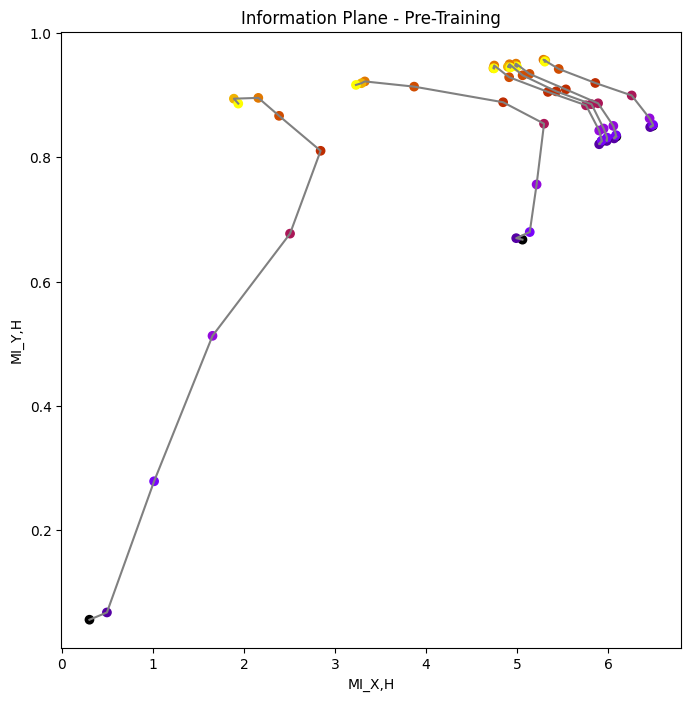

done!
        Train accuracy: 78.6820652173913


In [9]:
# Pre-training

task = tasks[0]
task_num = 0
print("Pre-Training")
accuracy = 0
N = 0

model.train()
parameters = list(model.parameters()) + list(class_heads[task_num].parameters())
optimizer = optim.SGD(parameters,
                        lr=offline_lr,
                        momentum=momentum,
                        weight_decay=weight_decay)
train_loader = get_train_loader(tasks[task_num])

print("        Epoch: ", end="")
for epoch in range(epochs):
    print(str(epoch+1) + ",", end="")
    for batch_idx, (images, labels) in enumerate(train_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        # forward pass
        h1, h2, h3, h4, h5 = model(images)
        h6 = F.log_softmax(class_heads[task_num](h5), dim = 1)
        loss = loss_function(h6, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]


    ### Calculate Mutual Information ###
    MI_XH[task_num, epoch], MI_YH[task_num, epoch] = compute_mutual_information(model, class_heads, 0, MI_loader)

    ### Calculate Test Performance ###
    update_test_tracker(test_tracker, model, class_heads, task_num, test_loaders)


plt.figure()
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel('MI_X,H')
ax.set_ylabel('MI_Y,H')
title = ax.set_title(f'Information Plane - Pre-Training')
cmap = plt.get_cmap('gnuplot', epochs)
colors = [cmap(i) for i in np.linspace(0, 1, epochs)]
ax.plot(MI_XH[task_num], MI_YH[task_num], '-', color='gray')
for layer in range(layers):
    im = ax.scatter(MI_XH[task_num, :,layer], MI_YH[task_num, :,layer], c=colors)

plt.show()

print("done!")
print("        Train accuracy:", 100. * accuracy/N)

Task: 2 / 2
        Epoch: 1,2,3,4,5,6,7,8,9,10,

<Figure size 640x480 with 0 Axes>

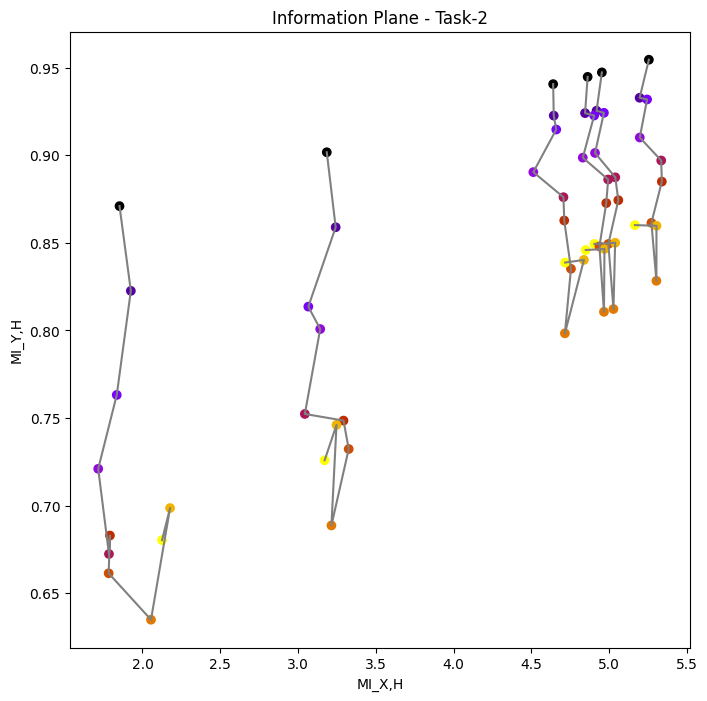

done!
        Train accuracy: 92.880859375
Task: 3 / 2
        Epoch: 1,2,3,4,5,6,7,8,9,10,

<Figure size 640x480 with 0 Axes>

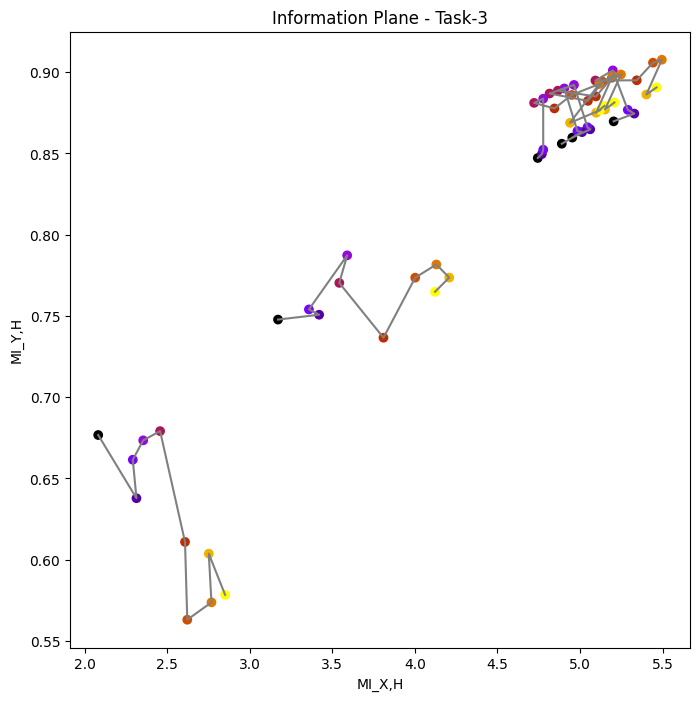

done!
        Train accuracy: 90.04415760869566


In [11]:
# Online Training
for task_num in range(1, len(tasks)):
    print("Task:", task_num+1, "/", len(tasks))
    accuracy = 0
    N = 0

    model.train()
    parameters = list(model.parameters()) + list(class_heads[task_num].parameters())
    optimizer = optim.SGD(parameters,
                          lr=offline_lr,
                          momentum=momentum,
                          weight_decay=weight_decay)
    train_loader = get_train_loader(tasks[task_num])

    print("        Epoch: ", end="")
    for epoch in range(epochs):
        print(str(epoch+1) + ",", end="")
        for batch_idx, (images, labels) in enumerate(train_loader, start=1):
            images, labels = images.to(device), labels.to(device)

            # forward pass
            h1, h2, h3, h4, h5 = model(images)
            h6 = F.log_softmax(class_heads[task_num](h5), dim = 1)
            loss = loss_function(h6, labels)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # check if predicted labels are equal to true labels
            predicted_labels = torch.argmax(h6,dim=1)
            accuracy += torch.sum((predicted_labels==labels).float()).item()
            N += images.shape[0]


        ### Calculate Mutual Information Offline Phase ###
        MI_XH[task_num, epoch], MI_YH[task_num, epoch] = compute_mutual_information(model, class_heads, 0, MI_loader)
        ### Calculate Test Performance ###
        update_test_tracker(test_tracker, model, class_heads, task_num, test_loaders)

    plt.figure()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlabel('MI_X,H')
    ax.set_ylabel('MI_Y,H')
    title = ax.set_title(f'Information Plane - Task-{task_num+1}')
    cmap = plt.get_cmap('gnuplot', epochs)
    colors = [cmap(i) for i in np.linspace(0, 1, epochs)]
    ax.plot(MI_XH[task_num], MI_YH[task_num], '-', color='gray')
    for layer in range(layers):
        im = ax.scatter(MI_XH[task_num, :,layer], MI_YH[task_num, :,layer], c=colors)

    plt.show()

    print("done!")
    print("        Train accuracy:", 100. * accuracy/N)

In [13]:
#@title Compute Forgetting Metrics
ave_accuracy        = []
ave_inc_accuracy    = []
forgetting_measure  = []
backward_transfer   = []

# Compute average accuracy
for task_num in range(len(tasks)):
    for epoch in range(epochs):
        ave_accuracy.append(0)
        for test_task_num in range(task_num + 1):
            ave_accuracy[-1] += test_tracker[task_num][test_task_num][epoch]
        ave_accuracy[-1] = ave_accuracy[-1] / (task_num+1)

# Compute backward transfer
for task_num in range(1, len(tasks)):
    for epoch in range(epochs):
        backward_transfer.append(0)
        for test_task_num in range(task_num):
            backward_transfer[-1] += test_tracker[task_num][test_task_num][epoch]
            backward_transfer[-1] -= test_tracker[test_task_num][test_task_num][-1]
        backward_transfer[-1] /= task_num
backward_transfer = [0] * epochs + backward_transfer

In [14]:
#@title Compute Mutual Information Aggregates
MI_XH_data = torch.flatten(MI_XH, start_dim=0, end_dim=1)
MI_YH_data = torch.flatten(MI_YH, start_dim=0, end_dim=1)
SE_X, SE_Y = compute_shannon_entropy(MI_loader)
MI_XH_perc = 100. * (MI_XH_data / SE_X)
MI_YH_perc = 100. * (MI_YH_data / SE_Y)
ave_MI_XH_perc = torch.mean(MI_XH_perc, dim=1)
ave_MI_YH_perc = torch.mean(MI_YH_perc, dim=1)

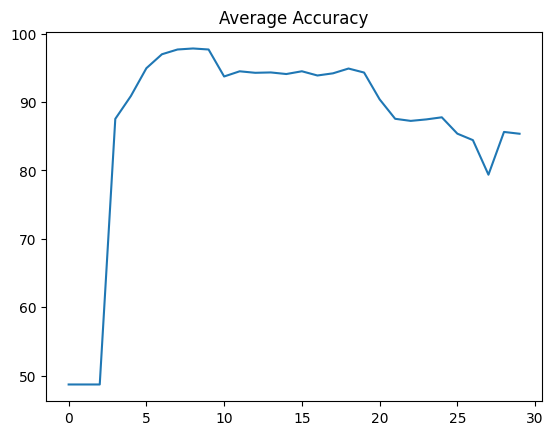

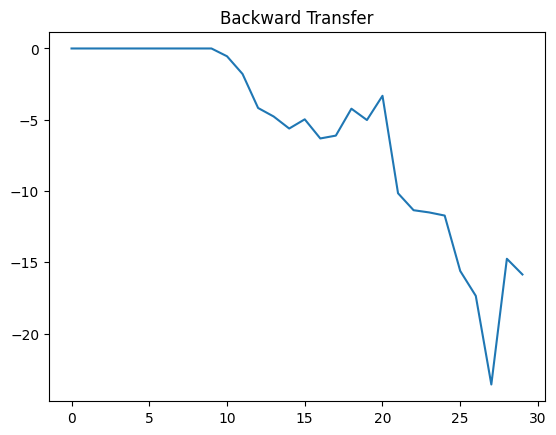

<Figure size 640x480 with 0 Axes>

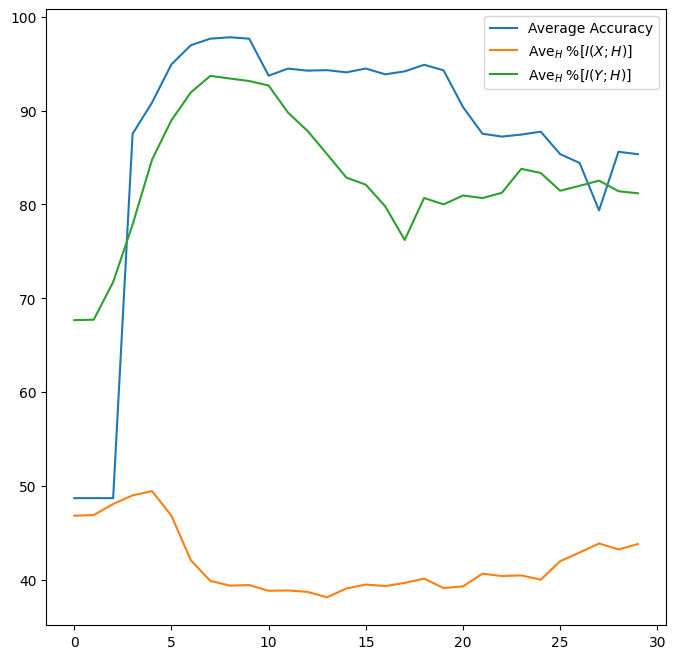

<Figure size 640x480 with 0 Axes>

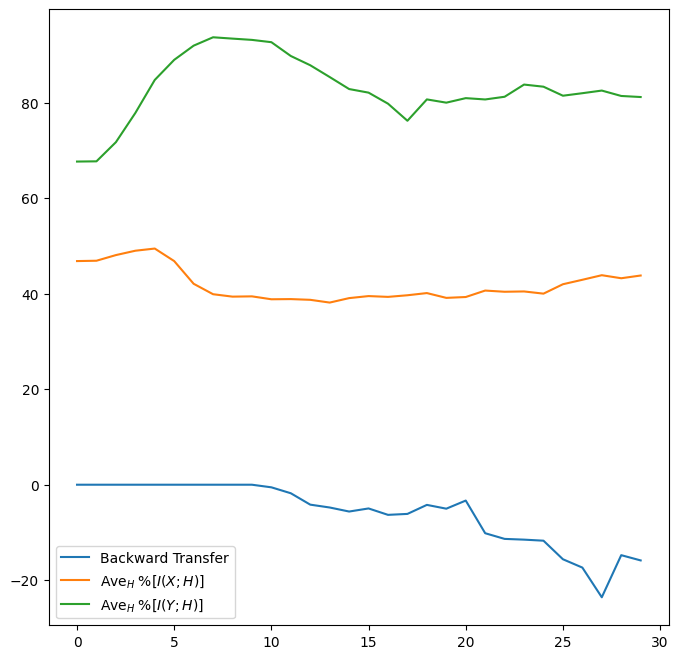

In [15]:
#@title Make Plots
plt.figure()
plt.title("Average Accuracy")
plt.plot(ave_accuracy)

plt.figure()
plt.title("Backward Transfer")
plt.plot(backward_transfer)

plt.figure()
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ave_accuracy, label="Average Accuracy")
ax.plot(ave_MI_XH_perc, label="$\mathrm{Ave}_H \; \%[I(X;H)]$")
ax.plot(ave_MI_YH_perc, label="$\mathrm{Ave}_H \; \%[I(Y;H)]$")
plt.legend()

plt.figure()
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(backward_transfer, label="Backward Transfer")
ax.plot(ave_MI_XH_perc, label="$\mathrm{Ave}_H \; \%[I(X;H)]$")
ax.plot(ave_MI_YH_perc, label="$\mathrm{Ave}_H \; \%[I(Y;H)]$")
plt.legend()

In [16]:
#@title Animation Function
def animate_task_MI(XH_data, YH_data):
    plt.figure()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlabel('MI_X,H')
    ax.set_xlim([0, XH_data.max() + 0.5])
    ax.set_ylim([0, YH_data.max() + 0.1])
    ax.set_ylabel('MI_Y,H')
    title = ax.set_title('Information Plane')
    # Construct epoch colour map (for dots)
    epochs = XH_data.size()[0]
    cmap_dots = plt.get_cmap('gnuplot', epochs+1)
    dot_colors = [cmap_dots(i) for i in np.arange(0, epochs+1)]

    # Construct layer colour map (for lines)
    layers = XH_data.size()[1]
    cmap_lines = plt.get_cmap('tab10', layers)
    line_colors = [cmap_lines(i) for i in np.arange(0, layers)]

    # initiate plot
    plots = {'layer': [], 'epoch': []}
    for layer in range(layers):
        x = XH_data[0,layer]
        y = YH_data[0,layer]
        plots["layer"].append(ax.plot(x, y, '-', color=line_colors[layer], label="Layer " + str(layer+1)))
        plots["epoch"].append(ax.scatter(x, y, c=dot_colors[0]))

    def update(frame):
        # update axis data
        for layer in range(layers):
            x = XH_data[:frame,layer]
            y = YH_data[:frame,layer]
            plots["layer"][layer][0].set_xdata(x)
            plots["layer"][layer][0].set_ydata(y)
            data = np.stack([x,y]).T
            plots["epoch"][layer].set_offsets(data)
        # update lines
    ani = animation.FuncAnimation(fig=fig, func=update, frames=XH_data.size()[0], interval=300)
    return ani

def animate_all_MI(XH_data, YH_data):
    plt.figure()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlabel('MI_X,H')
    ax.set_xlim([0, XH_data.max() + 0.5])
    ax.set_ylim([0, YH_data.max() + 0.1])
    ax.set_ylabel('MI_Y,H')
    title = ax.set_title('Information Plane')
    # Construct epoch colour map (for dots)
    tasks = XH_data.size()[0]
    epochs = XH_data.size()[1]
    cmap_dots = plt.get_cmap('gnuplot', tasks)
    dot_colors = []
    for task in range(tasks):
        dot_colors += [cmap_dots(task)] * epochs

    # Construct layer colour map (for lines)
    layers = XH_data.size()[2]
    cmap_lines = plt.get_cmap('tab10', layers)
    line_colors = [cmap_lines(i) for i in np.arange(0, layers)]

    XH_data = torch.flatten(XH_data, start_dim=0, end_dim=1)
    YH_data = torch.flatten(YH_data, start_dim=0, end_dim=1)

    # initiate plot
    plots = {'layer': [], 'epoch': []}
    for layer in range(layers):
        x = XH_data[0, layer]
        y = YH_data[0, layer]
        plots["layer"].append(ax.plot(x, y, '-', color=line_colors[layer], label="Layer " + str(layer+1)))
        plots["epoch"].append(ax.scatter(x, y, c=dot_colors[0]))

    def update(frame):
        # update axis data
        for layer in range(layers):
            x = XH_data[:frame,layer]
            y = YH_data[:frame,layer]
            plots["layer"][layer][0].set_xdata(x)
            plots["layer"][layer][0].set_ydata(y)
            data = np.stack([x,y]).T
            plots["epoch"][layer].set_offsets(data)
            plots["epoch"][layer].set_color(dot_colors[:frame])
        # update lines
    ani = animation.FuncAnimation(fig=fig, func=update, frames=XH_data.size()[0], interval=300)
    return ani

<ipython-input-16-803d8846c9fa>:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plots["epoch"].append(ax.scatter(x, y, c=dot_colors[0]))
<ipython-input-16-803d8846c9fa>:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plots["epoch"].append(ax.scatter(x, y, c=dot_colors[0]))
<ipython-input-16-803d8846c9fa>:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mappi

<Figure size 640x480 with 0 Axes>

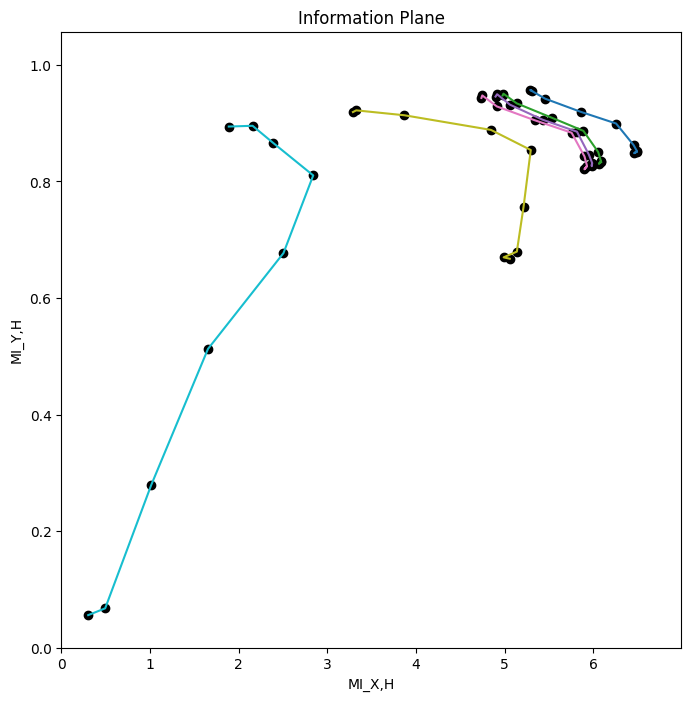

<Figure size 640x480 with 0 Axes>

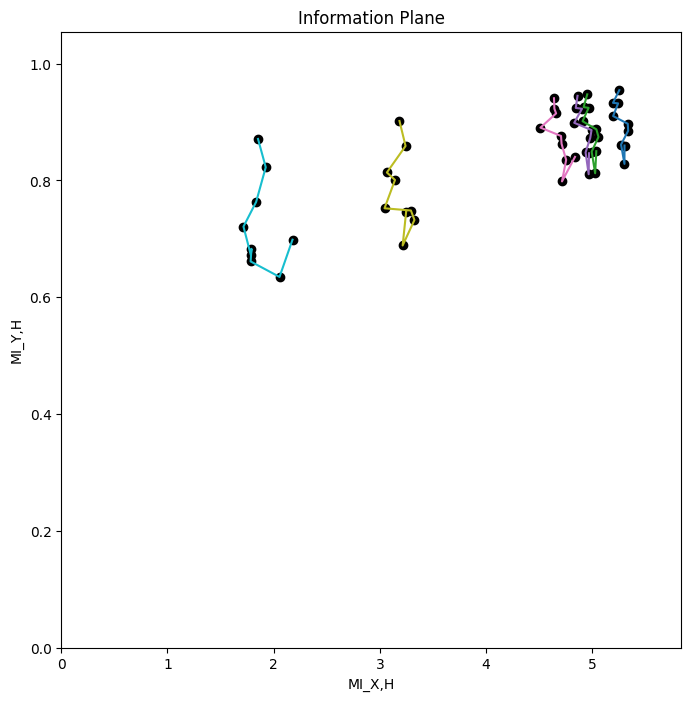

<Figure size 640x480 with 0 Axes>

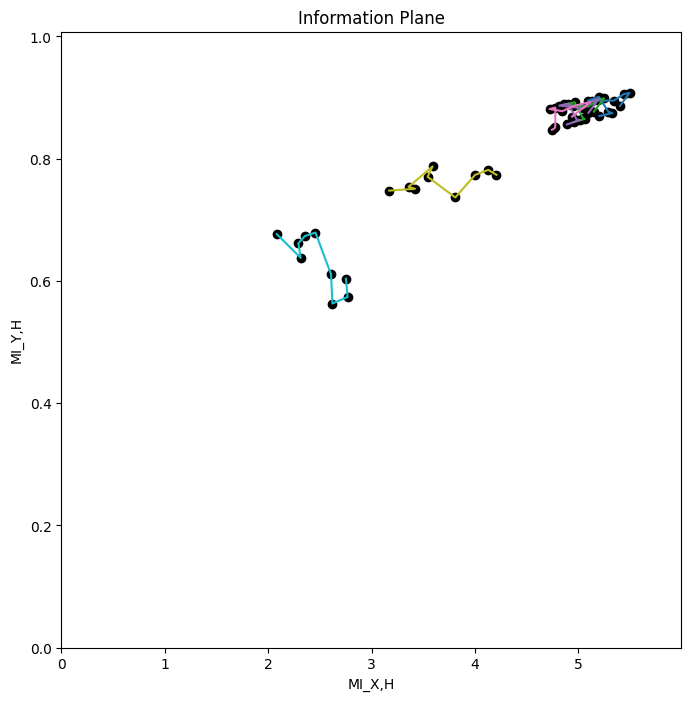

<Figure size 640x480 with 0 Axes>

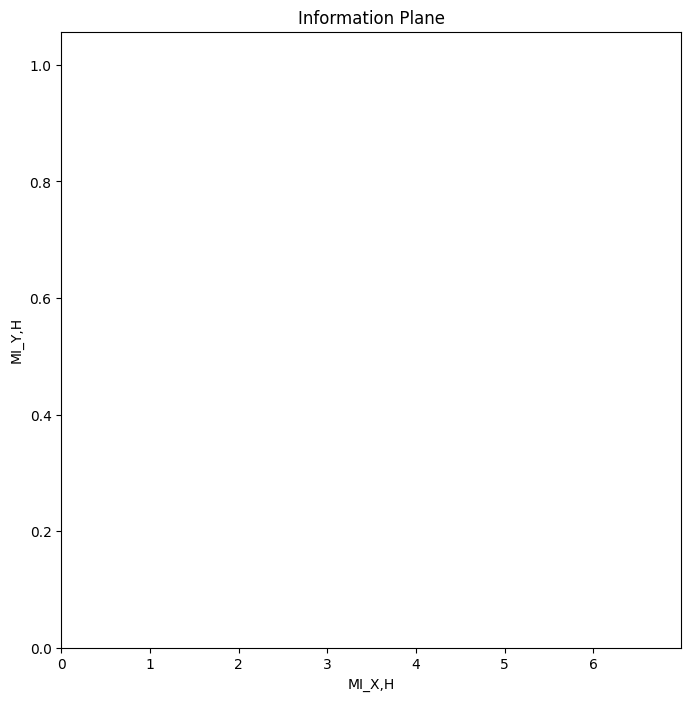

In [18]:
#@title Animation
ani = animate_task_MI(MI_XH[0,:,:], MI_YH[0,:,:])
ani.save("ibl_task0.gif", writer="pillow")
ani = animate_task_MI(MI_XH[1,:,:], MI_YH[1,:,:])
ani.save("ibl_task1.gif", writer="pillow")
ani = animate_task_MI(MI_XH[2,:,:], MI_YH[2,:,:])
ani.save("ibl_task2.gif", writer="pillow")
ani = animate_all_MI(MI_XH, MI_YH)
ani.save("ibl_all_tasks.gif", writer="pillow")